In [1]:
# --- Imports ---
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.base import clone
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder


# Models
from sklearn.naive_bayes import CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, roc_auc_score
import time
from matplotlib import pyplot
import warnings
warnings.filterwarnings('ignore')
import joblib  # for saving trained models
joblib.parallel_backend('threading', n_jobs=1)
from sklearn.model_selection import GridSearchCV


In [2]:
train = pd.read_csv('train1.csv')
test  = pd.read_csv('test.csv')   # used to generate final submission

# Identify target and id (adjust names if different)
TARGET = 'target'   # change if different
ID_COL = 'id'       # change if different

# quick shape
print("Train shape:", train.shape)
print("Test shape: ", test.shape)


Train shape: (296209, 67)
Test shape:  (126948, 66)


In [5]:
X = train.drop('target', axis=1)
y = train['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


binary_cols = [col for col in X_train.columns if X_train[col].dropna().nunique() == 2]
other_cols = [col for col in X_train.columns if col not in binary_cols]

# Imputer for binary columns
binary_imputer = SimpleImputer(strategy='most_frequent')
X_train[binary_cols] = binary_imputer.fit_transform(X_train[binary_cols])
X_test[binary_cols] = binary_imputer.transform(X_test[binary_cols])

# Imputer for other numeric columns
num_imputer = SimpleImputer(strategy='mean')
X_train[other_cols] = num_imputer.fit_transform(X_train[other_cols])
X_test[other_cols] = num_imputer.transform(X_test[other_cols])


In [6]:
X_train.isna().sum().sum(), X_test.isna().sum().sum() #no more Na columns


(0, 0)

In [7]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal')
X_train[other_cols] = qt.fit_transform(X_train[other_cols])
test[other_cols] = qt.transform(test[other_cols])


In [10]:
print("Target distribution:\n", y_train.value_counts(normalize=True))


Target distribution:
 target
0    0.949037
1    0.050963
Name: proportion, dtype: float64


Top features by Mutual Information:


ps_ind_05_cat    0.0509
feature1         0.0473
ps_ind_14        0.0376
ps_car_04_cat    0.0265
ps_ind_02_cat    0.0228
ps_car_11        0.0190
ps_car_01_cat    0.0103
ps_car_09_cat    0.0099
ps_calc_12       0.0079
feature5         0.0078
ps_car_06_cat    0.0076
ps_reg_01        0.0075
ps_ind_01        0.0070
feature2         0.0067
ps_car_12        0.0051
ps_reg_02        0.0047
ps_car_11_cat    0.0041
ps_calc_07       0.0040
ps_calc_08       0.0039
ps_calc_11       0.0038
feature8         0.0038
ps_calc_06       0.0036
ps_calc_09       0.0035
feature3         0.0034
ps_calc_14       0.0034
ps_calc_04       0.0033
ps_calc_05       0.0033
ps_calc_01       0.0033
ps_calc_03       0.0032
ps_calc_02       0.0032
dtype: float64

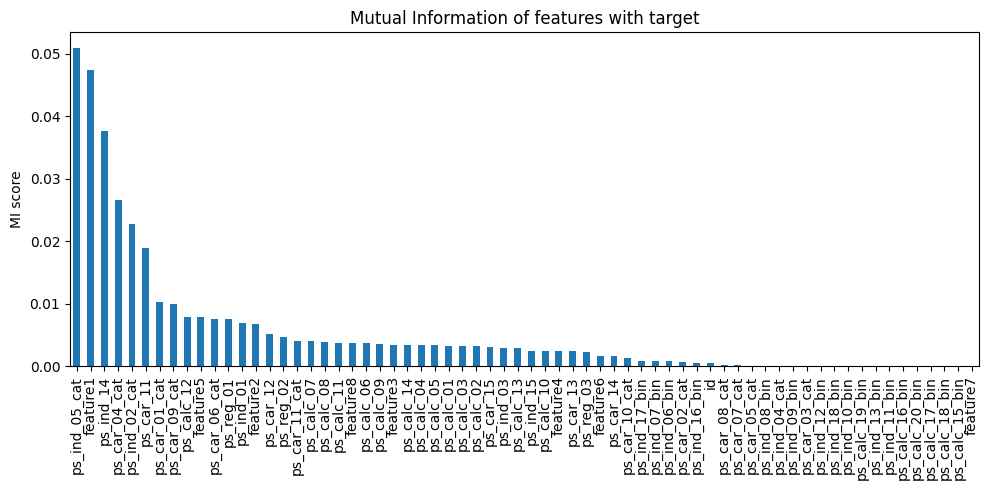


Selected top-30 features by MI:
['ps_ind_05_cat', 'feature1', 'ps_ind_14', 'ps_car_04_cat', 'ps_ind_02_cat', 'ps_car_11', 'ps_car_01_cat', 'ps_car_09_cat', 'ps_calc_12', 'feature5', 'ps_car_06_cat', 'ps_reg_01', 'ps_ind_01', 'feature2', 'ps_car_12', 'ps_reg_02', 'ps_car_11_cat', 'ps_calc_07', 'ps_calc_08', 'ps_calc_11', 'feature8', 'ps_calc_06', 'ps_calc_09', 'feature3', 'ps_calc_14', 'ps_calc_04', 'ps_calc_05', 'ps_calc_01', 'ps_calc_03', 'ps_calc_02']


In [11]:
# Mutual information based feature selection
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

# feature names in current X_train (after imputation and any poly features you created)
feature_names = list(X_train.columns)

# Build discrete_features mask: True for binary / categorical-like columns
# If you also have explicit cat_cols (ps_*_cat), include them here.
# For your previous pipeline you had `binary_cols` (0/1). If you have other categorical columns add them too.
discrete_mask = [col in binary_cols for col in feature_names]

# Compute mutual information (classification)
mi = mutual_info_classif(X_train[feature_names], y_train, discrete_features=discrete_mask, random_state=42)

# Put into a sorted Series for viewing
mi_series = pd.Series(mi, index=feature_names).sort_values(ascending=False)

# Print top features
print("Top features by Mutual Information:")
display(mi_series.head(30).round(4))

# Plot MI scores
plt.figure(figsize=(10,5))
mi_series.plot.bar()
plt.title('Mutual Information of features with target')
plt.ylabel('MI score')
plt.tight_layout()
plt.show()

# Choose top-k features (e.g., top 22 or dynamic)
k = 30
selected_mi = mi_series.index[:k].tolist()
print(f"\nSelected top-{k} features by MI:\n{selected_mi}")

# Filter your train/test sets accordingly
X_train_mi = X_train[selected_mi]
X_test_mi  = X_test[selected_mi]


In [17]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from sklearn.neural_network import MLPClassifier



# ================================
# CONFIG
# ================================
k_features = 15
cv_folds = 5

selected_features = [
    'ps_ind_05_cat', 'feature1', 'ps_ind_14', 'ps_car_04_cat', 
    'ps_ind_02_cat', 'ps_car_11', 'ps_car_01_cat', 'ps_car_09_cat', 
    'ps_calc_12', 'feature5', 'ps_car_06_cat', 'ps_reg_01', 
    'ps_ind_01', 'feature2', 'ps_car_12', 'ps_reg_02', 
    'ps_car_11_cat', 'ps_calc_07', 'ps_calc_08', 'ps_calc_11', 
    'feature8', 'ps_calc_06', 'ps_calc_09', 'feature3', 
    'ps_calc_14', 'ps_calc_04', 'ps_calc_05', 'ps_calc_01', 
    'ps_calc_03', 'ps_calc_02'
]

X_fs = X_train[selected_features]
y_fs = y_train

# ================================
# MODELS (patched)
# ================================
models = {
    'CatBoost': CatBoostClassifier(
        verbose=0,
        random_state=42,
        cat_features=[],        # ensures CatBoost treats all as numeric
        allow_const_label=True  # suppresses constant-label folds
    ),
    'LightGBM': lgb.LGBMClassifier(random_state=42, min_data_in_leaf=10, min_gain_to_split=0.0, force_col_wise=True, n_jobs=1),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss', random_state=42, use_label_encoder=False),
    'MLP': Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=200, random_state=42))
    ])
}

# ================================
# FORWARD SELECTION
# ================================
results = {}

# Drop constant or near-constant features
from sklearn.feature_selection import VarianceThreshold
X_fs = VarianceThreshold(threshold=0.0).fit_transform(X_fs)


for name, model in models.items():
    print(f"\n🚀 Running Forward Selection for {name} (target: {k_features} features)...")

    start_time = time.time()

    sfs = SFS(
        model,
        k_features=k_features,
        forward=True,
        floating=False,
        scoring='roc_auc',
        cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42),
        n_jobs=1,            # keep 1 for safety
        pre_dispatch='2*n_jobs',
        verbose=2
    )

    try:
        sfs = sfs.fit(X_fs, y_fs)
        duration = time.time() - start_time
        selected = list(sfs.k_feature_names_)
        best_score = sfs.k_score_

        print(f"\n✅ {name} SFS Complete")
        print(f"Best {k_features} features: {selected}")
        print(f"Validation AUROC: {best_score:.4f}")
        print(f"Training time: {duration/60:.1f} minutes")

        results[name] = {
            "features": selected,
            "auroc": best_score,
            "time_min": duration/60
        }

    except Exception as e:
        print(f"❌ {name} failed: {e}")

print("\n📊 Summary of Forward Selection Results:")
for model, info in results.items():
    print(f"{model}: AUROC={info['auroc']:.4f}, Time={info['time_min']:.1f} min")



🚀 Running Forward Selection for CatBoost (target: 15 features)...


[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed: 113.4min finished

[2025-10-23 19:52:10] Features: 1/15 -- score: 0.5690389604550669[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed: 132.8min finished

[2025-10-23 22:04:59] Features: 2/15 -- score: 0.5779772338458925[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 128.6min finished

[2025-10-24 00:13:38] Features: 3/15 -- score: 0.587403338508669[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed: 129.9min finished

[2025-10-24 02:23:34] Features: 4/15 -- score: 0.5937068736171147[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 122.1min finished

[2025-10-24 04:25:43] Features: 5/15 -- score: 0.5942819627570536[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 113.6min finished

[2025-10-24 06:19:19] Features: 6/15 -- score: 0.5964629581984806[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed: 527.8min finished

[2025-10-24 15:07:09] Features: 7/15 -- score: 0.5965969880454566

❌ CatBoost failed: 'Parallel' object has no attribute '_pre_dispatch_amount'

🚀 Running Forward Selection for LightGBM (target: 15 features)...
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Info] Number of positive: 8453, number of negative: 157423
[LightGBM] [Info] Total Bins 9
[LightGBM] [Info] Number of data points in the train set: 165876, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.050960 -> initscore=-2.924415
[LightGBM] [Info] Start training from score -2.924415
[LightGBM] [Warning] No further spl